In [1]:
import numpy as np
from astropy import units as u
from astropy import constants as const
import matplotlib.pyplot as plt

home = '/Users/lieke/surfdrive/Documents/'
proj_dir = home + 'CEinLISA/'

## LISA strain simple approx

In [2]:
m1 = 0.5*u.Msun
m2 = 0.3*u.Msun
# Porb = 0.5*u.day#*24.*60.*60.   # s

def Pkeppler(m1, m2, a):
    a = a.to(u.m)
    m1 = m1.to(u.kg)
    m2 = m2.to(u.kg)
    P = (( (2*np.pi)**2 * a**3)* (const.G * (m1 + m2))**-1 )**0.5
    return P.to(u.day)

a = 1.47*u.Rsun
print('Pkeppler',Pkeppler(m1, m2, a))
Porb = Pkeppler(m1, m2, a)

f_gw = 2.*(Porb.to(u.s))**-1  # Hz
print('f_gw', np.log10(f_gw.value) )

mchirp = ((m1*m2)**(3./5.))/((m1+m2)**(1./5.))
print( 'mchirp', mchirp)
mchirp = mchirp.to(u.kg)
print( 'mchirp', mchirp)

d = 100*u.pc#6e4 # pc
d = d.to(u.m)
# d_AU = d*u.pc.to(u.AU)
# f_gw_day = f_gw/(u.s.to(u.day))

A_mean = (2.*((const.G*mchirp)**(5./3.))/((const.c**4.)*d))*((np.pi*f_gw)**(2./3.))
print('A_mean', A_mean)
Tobs = 10. *u.yr  # yrs
Tobs = Tobs.to(u.s)
# Tobs_s = Tobs*365.25*24.*60.*60.
hc = A_mean*np.sqrt(f_gw*Tobs)

print('hc',  np.log10(hc) )

Pkeppler 0.23082047081033671 d
f_gw -3.9987580693476845
mchirp 0.334993791331143 solMass
mchirp 6.661049613054079e+29 kg
A_mean 2.0728688618498193e-22
hc -19.43325522341097


In [2]:
m1 = 0.5
m2 = 0.5
mchirp = ((m1*m2)**(3./5.))/((m1+m2)**(1./5.))
print('mchirp',mchirp )


mchirp 0.43527528164806206


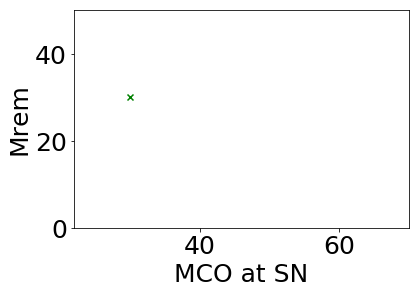

In [3]:
# overplot figures to get a beta value

# img = plt.imread("/Users/lieke/Documents/screenshots/Fragos2019.png")
# fig, ax = plt.subplots(figsize = (10,10))
# ax.imshow(img, extent=[22, 70, 0, 50])

# plt.scatter(snfarmCO['MassCOCoreSN'], snfarmCO['Mrem'], alpha = 0.5, label = 'Farmer CO core 2019',s = 25, c = 'limegreen')
plt.scatter(30,30, marker = 'x', c = 'green')

# xlijst = np.arange(22,70, 0.5)
# print(len(xlijst))
# plt.plot(xlijst,  farm_theory(xlijst, z = 1e-3), alpha = 1, label = '',c = 'white', linewidth = 4)
# xmax = -8.564/(2*-0.096)
# print('max Mrem = ', farm_theory([xmax], z = 1e-3))

plt.xlabel('MCO at SN', fontsize = 25)
plt.ylabel('Mrem', fontsize = 25)
# plt.legend(loc = 'lower left', fontsize = 25, framealpha = 1)

plt.xlim(22,70)
plt.ylim(0,50)

plt.tick_params(axis='both', which='major', labelsize=25) #right side
# plt.savefig('/home/ason/BHinPISNgap/Plots/Farmer/Compare_plot_Mco_Mrem.png', bbox_inches='tight')

plt.show()


In [4]:
m1 = 1.6*u.Msun
m2 = 0.3*u.Msun
a = 126 * u.Rsun
Porb = Pkeppler(m1, m2, a)
print(Porb)



118.85633409283827 d


# Calculating the final separations for theoretical RSGs



afinal 1.0825021458820019 solRad


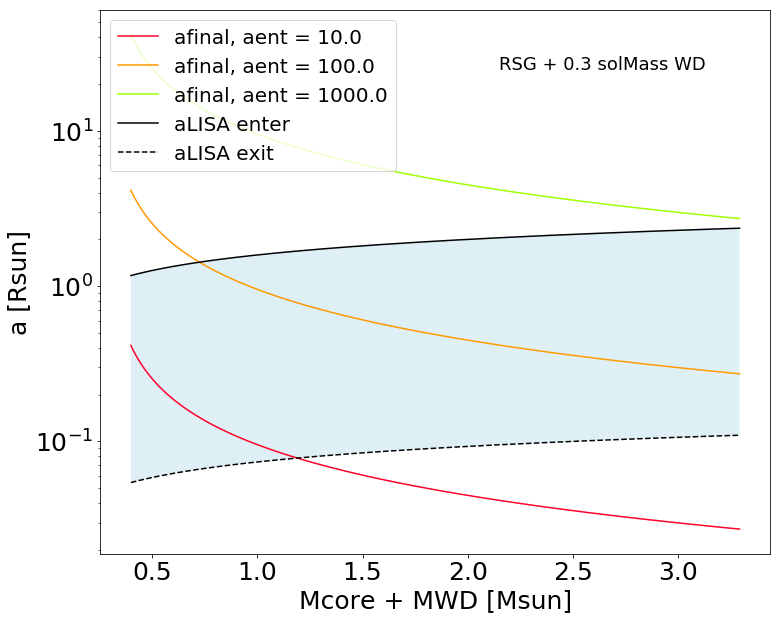

In [5]:
rainbow = plt.cm.gist_rainbow(np.linspace(0,1, 8) ) #3rd num is the number of colours


def Rrl(a, m1, m2):
    #RL1 for q = m1/m2
    q = m1/m2
    RL = a * 0.49 * q**(2./3) *(0.6 * q**(2./3) +np.log(1 + q**(1./3)) )**-1
    return RL
    

def aLISA(mass):
    min_freq = 1e-4 *u.s**-1
    mass = mass.to(u.kg)
    a = pow(const.G * mass * (np.pi * min_freq)**-2, 1./3. )
    return a.to(u.Rsun)

def aLISAexit(mass):
    min_freq = 1e-2 *u.s**-1
    mass = mass.to(u.kg)
    a = pow(const.G * mass * (np.pi * min_freq)**-2, 1./3. )
    return a.to(u.Rsun)

def afinal(Mdcore = 1*u.Msun, Mdenv= 1*u.Msun, Mcomp= 1*u.Msun, a_ent= 1*u.Rsun, alpha=1.0, Lambda= 0.5):
    Mdon = Mdcore + Mdenv
    Rrld = Rrl(a_ent, Mdon, Mcomp)
#     print('Rrld', Rrld)
    afinal = (Mdcore*Mcomp)/2 * ( (Mdon*Mdenv)/(Lambda*Rrld) + (Mdon*Mcomp)/(2*a_ent) )**-1
    return afinal

print('afinal', afinal(Mdcore = 0.5*u.Msun, Mdenv = 1.1*u.Msun, Mcomp= 0.3*u.Msun, a_ent= 100*u.Rsun, alpha=1., Lambda=0.5) )
# afinal_Ivanova = afinal(Mdcore = 0.5*u.Msun, Mdenv = 1.1*u.Msun, Mcomp= companion_mass, a_ent= 100*u.Rsun, alpha=1., Lambda=0.5) )

def plot_afinal_Mgw(companion_mass = 0.3):
    #companion_mass The withe dwarf falling into the envelope

    fig, ax = plt.subplots(figsize=(12,10))

    core_masses = np.arange(0.1, 3, 0.01) #Donor core masses
    masses = core_masses + companion_mass

    donor_envelope_masses = core_masses *2*u.Msun   #ballpack estimate

    #Add units
    companion_mass = companion_mass*u.Msun 
    core_masses = core_masses*u.Msun
    masses = masses*u.Msun

    a_enters = np.logspace(1, 3, 3)
    for i, a in enumerate(a_enters):
        afinals = afinal(Mdcore = core_masses, Mdenv = donor_envelope_masses, Mcomp= companion_mass, a_ent= a*u.Rsun, alpha=1., Lambda=0.5) 
        plt.plot(masses, afinals, label = 'afinal, aent = '+str(a), c = rainbow[i] )


    ax.fill_between(masses, aLISAexit(masses), aLISA(masses),\
                              facecolor='lightblue',  alpha=0.4)
    plt.plot(masses, aLISA(masses), label = 'aLISA enter', c = 'k')
    plt.plot(masses, aLISAexit(masses), label = 'aLISA exit', c = 'k', linestyle='--')

    plt.text(0.75, 0.9, 'RSG + '+str(companion_mass)+' WD', fontsize = 18, horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
    
    plt.legend(fontsize = 20, loc = 'upper left')
    plt.xlabel('Mcore + MWD [Msun]',size = 25)
    plt.ylabel('a [Rsun]',size = 25)
    plt.tick_params(axis='both', which='major', labelsize=25) #right side
    plt.yscale('log')
    plt.savefig(proj_dir+'/a_Mcore_Mwd'+str(companion_mass.value).replace('.', 'd')+'.png', bbox_inches='tight')

    plt.show()


plot_afinal_Mgw(companion_mass = 0.3)



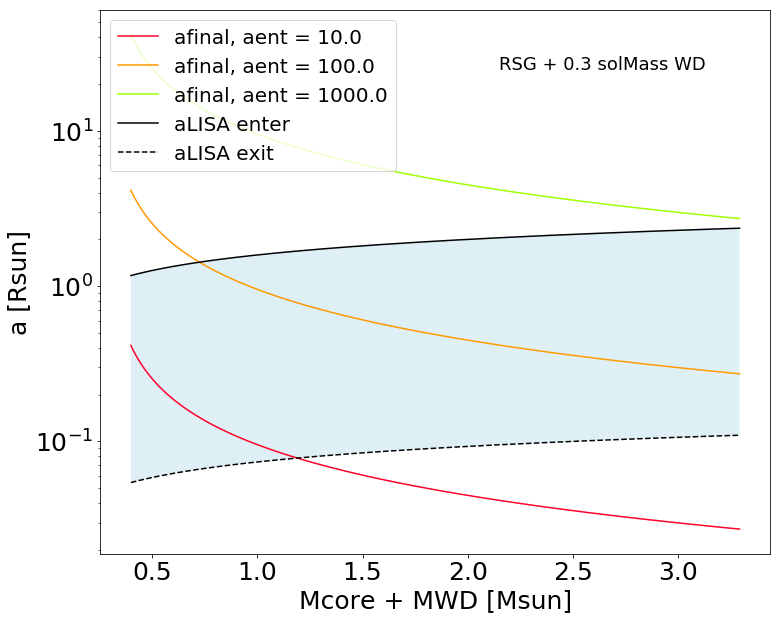

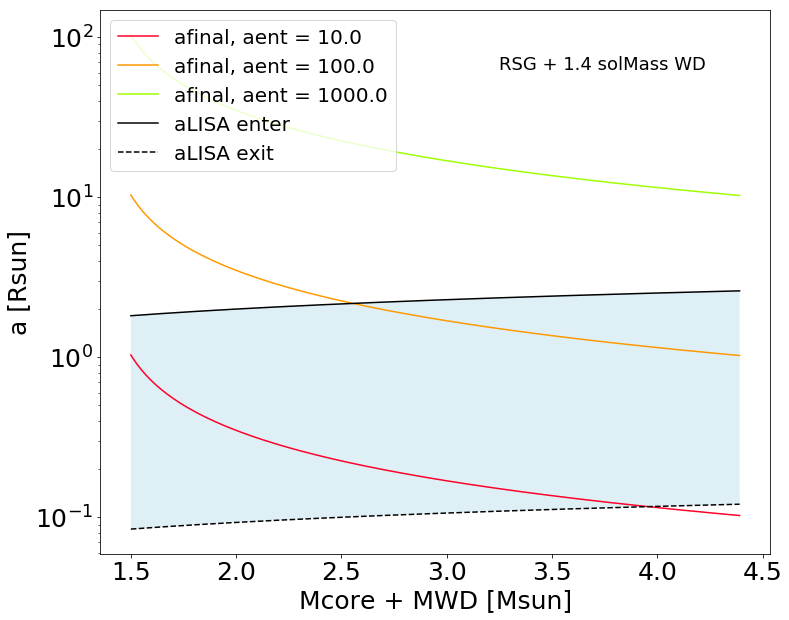

In [6]:
plot_afinal_Mgw(companion_mass = 0.3)

plot_afinal_Mgw(companion_mass = 1.4)
